# Image Classification using AWS Sagemaker

This notebook will allow the interaction with AWS Sagemaker. Through data extraction, determining the best hyperparameters and submit and deploy the model dor inference. It will contain also the progiling and debugging information.

In [15]:
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp311-cp311-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker 2.227.0 requires boto3<2.0,>=1.34.142, but you have boto3 1.34.131 which is incompatible.


In [26]:
!pip install bokeh

  Using cached xyzservices-2024.9.0-py3-none-any.whl.metadata (4.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.6 MB/s eta 0:00:00
Using cached xyzservices-2024.9.0-py3-none-any.whl (85 kB)


In [116]:
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
import boto3
import sys
import os
import numpy as np

from sagemaker.pytorch import PyTorch
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.debugger import Rule,ProfilerRule,rule_configs
from sagemaker.debugger import DebuggerHookConfig,ProfilerConfig,FrameworkProfile,CollectionConfig

## Dataset
The dataset used for this project is a dog breed classification dataset. The dataset contains images from 133 dog breeds divided into training, testing and validation datasets.

* The training folder includes 6680 items

* The validation folder includes 835 items

* The testing folder includes 836 items

In [3]:
sagemaker_session = sagemaker.Session()
bucket = 'martom'
role = sagemaker.get_execution_role()

In [4]:
# Command to download and unzip data - run only once when needed
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip --no-check-certificate
# !unzip dogImages.zip

In [5]:
# Fetch and upload the data to AWS S3 - run only once when needed
# local_dir = 'dogImages'
# prefix = "image_classification_project"
# inputs = sagemaker_session.upload_data(path=local_dir, bucket=bucket, key_prefix=prefix)


In [6]:
# print(f"S3 path: {inputs}")
# s3://martom/image_classification_project

## Hyperparameter Tuning
In this part we will finetune a pretrained ResNet model using the below hyperparameters:
* learning rate: to have a faster convergence
* batch size: to have an efficient training time
* epochs: to have an efficient training time

`hpo.py` script will be used for that purpose.

In [69]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.01, 0.5),
    "batch-size": CategoricalParameter([8, 16, 32, 64]),
    "epochs": IntegerParameter(2, 5),
}

objective_metric_name = "Accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Accuracy", "Regex": "Test set: Accuracy: ([0-9\\.]+)%"}]

In [70]:
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version="1.8",
    py_version="py36",
)

In [71]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=1,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

In [20]:
inputs = "s3://martom/image_classification_project/"

In [73]:
tuner.fit({"training": inputs}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-241128-1307


............................................................................................................................................................................................................................................................................................................................................................!


In [74]:
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-11-28 13:36:11 Starting - Preparing the instances for training
2024-11-28 13:36:11 Downloading - Downloading the training image
2024-11-28 13:36:11 Training - Training image download completed. Training in progress.
2024-11-28 13:36:11 Uploading - Uploading generated training model
2024-11-28 13:36:11 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"Accuracy"',
 'batch-size': '"16"',
 'epochs': '3',
 'lr': '0.22721942209010104',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2024-11-28-13-07-36-811"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-503316288787/pytorch-training-2024-11-28-13-07-36-811/source/sourcedir.tar.gz"'}

In [75]:
tuner.best_training_job()

'pytorch-training-241128-1307-001-9d6226f4'

In [76]:
hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')),
                   "lr": best_estimator.hyperparameters()['lr'],
                   "epochs": int(best_estimator.hyperparameters()['epochs'].replace('"', ''))
                  }
hyperparameters

{'batch-size': 16, 'lr': '0.22721942209010104', 'epochs': 3}

In [16]:
hyperparameters = {'batch-size': 16, 'lr': '0.22721942209010104', 'epochs': 3}

## Model Profiling and Debugging
After selecting the best hyperparameters we can finally train the best model using `train_model.py` script. We will also implement profiling and debugging.

In [17]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [18]:
estimator_deb = PyTorch(
    entry_point="train_model.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)



In [21]:
estimator_deb.fit({"training": inputs}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-12-06-08-56-45-233


2024-12-06 08:56:50 Starting - Starting the training job...
2024-12-06 08:57:19 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
LowGPUUtilization: InProgress
...
2024-12-06 08:57:39 Downloading - Downloading input data......
2024-12-06 08:58:52 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-12-06 08:59:08,457 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-12-06 08:59:08,460 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-12-06 08:59:08,469 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-12-06 08:59:08,471 sagemaker_pytorch_container.training INFO     Invoking user training script.

In [22]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator_deb.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2024-12-06-08-56-45-233
Region: us-east-1


In [23]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator_deb.latest_job_debugger_artifacts_path())
trial.tensor_names()

[2024-12-06 09:23:29.359 default:194 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-12-06 09:23:29.376 default:194 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-503316288787/pytorch-training-2024-12-06-08-56-45-233/debug-output
[2024-12-06 09:23:31.602 default:194 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-12-06 09:23:32.622 default:194 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.bias',
 'gradient/ResNet_fc.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.relu_input_2',
 'layer3.4.relu_input_0',
 'layer3.4.relu_input_1',
 '

In [27]:
import bokeh

In [28]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-503316288787/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-503316288787/pytorch-training-2024-12-06-08-56-45-233/profiler-output


Profiler data from system is available


In [29]:
rule_output_path = estimator_deb.output_path + estimator_deb.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-503316288787/pytorch-training-2024-12-06-08-56-45-233/rule-output


In [30]:
! aws s3 ls {rule_output_path} --recursive

2024-12-06 09:23:18     375260 pytorch-training-2024-12-06-08-56-45-233/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-12-06 09:23:17     223180 pytorch-training-2024-12-06-08-56-45-233/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-12-06 09:23:13        192 pytorch-training-2024-12-06-08-56-45-233/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-12-06 09:23:13        200 pytorch-training-2024-12-06-08-56-45-233/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-12-06 09:23:13       1960 pytorch-training-2024-12-06-08-56-45-233/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-12-06 09:23:13        127 pytorch-training-2024-12-06-08-56-45-233/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-12-06 09:23:13        199 pytorch-training-2024-12-06-08-56-45-233/rule-output/ProfilerReport/profiler-output/profiler-re

In [31]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-503316288787/pytorch-training-2024-12-06-08-56-45-233/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-503316288787/pytorch-training-2024-12-06-08-56-45-233/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-503316288787/pytorch-training-2024-12-06-08-56-45-233/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-503316288787/pytorch-training-2024-12-06-08-56-45-233/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-503316288787/pytorch-traini

In [32]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator_deb.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [33]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [34]:
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.predictor import Predictor

In [35]:
sagemaker_session = sagemaker.Session()
bucket = 'martom'
role = sagemaker.get_execution_role()

In [36]:
from sagemaker.pytorch import PyTorchModel
model_data = estimator_deb.output_path + estimator_deb.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model: {model_data}")

Model: s3://sagemaker-us-east-1-503316288787/pytorch-training-2024-12-06-08-56-45-233/output/model.tar.gz


In [37]:
# Already trained estimator_deb
model_data = "s3://sagemaker-us-east-1-503316288787/pytorch-training-2024-12-06-08-56-45-233/output/model.tar.gz"

In [119]:
model = PyTorchModel(
    model_data=model_data,
    role=role,
    entry_point="deploy_model.py",
    py_version='py36',
    framework_version="1.8"
)

predictor = model.deploy(
    initial_instance_count=1, 
    instance_type="ml.m5.xlarge"
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-503316288787/pytorch-training-2024-12-06-08-56-45-233/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-503316288787/pytorch-inference-2024-12-06-13-45-38-136/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-12-06-13-45-48-184
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-12-06-13-45-48-948
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-12-06-13-45-48-948


-------!

In [120]:
endpoint_name = predictor.endpoint_name
print("Endpoint: {}".format(predictor.endpoint_name))

Endpoint: pytorch-inference-2024-12-06-13-45-48-948


In [121]:
from PIL import Image
import torchvision.transforms as transforms

In [122]:
pwd

'/home/sagemaker-user/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter'

In [123]:
image_path = "./dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg"

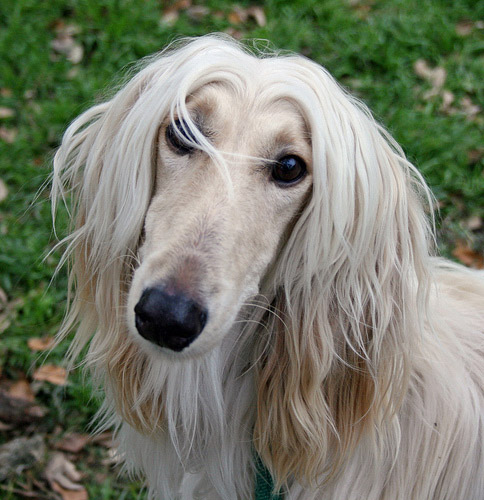

In [124]:
img = Image.open(image_path)
display(img)

In [125]:
transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
        ])
preprocessed_image = transform(img).unsqueeze(0)
preprocessed_image = preprocessed_image.to("cpu")
response = predictor.predict(preprocessed_image)

pred = np.argmax(response, 1) + 1

actual = int(image_path.split('.')[1].split('/')[-1])
print(f"Actual: {actual}, Prediction: {pred[0]}")

Actual: 2, Prediction: 2


In [126]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-12-06-13-45-48-948
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-12-06-13-45-48-948
